# Customer Segmentation Analysis Using Hierarchical Clustering

This analysis aims to segment customers based on their purchasing patterns using RFM metrics and hierarchical clustering.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")  # Suppress warnings to maintain clean output


## Data Loading and Description

First, we load the sales and customer demographic datasets and provide a statistical summary to understand their structure and content.


In [4]:
# Load data from CSV and Excel files for analysis
df_sales = pd.read_csv('../data/Online_Sales.csv')
df_customers = pd.read_excel('../data/CustomersData.xlsx')

# Display initial descriptive statistics to assess data quality and understand distribution
print(df_sales.describe())
print(df_customers.describe())

        CustomerID  Transaction_ID      Quantity     Avg_Price  \
count  52924.00000    52924.000000  52924.000000  52924.000000   
mean   15346.70981    32409.825675      4.497638     52.237646   
std     1766.55602     8648.668977     20.104711     64.006882   
min    12346.00000    16679.000000      1.000000      0.390000   
25%    13869.00000    25384.000000      1.000000      5.700000   
50%    15311.00000    32625.500000      1.000000     16.990000   
75%    16996.25000    39126.250000      2.000000    102.130000   
max    18283.00000    48497.000000    900.000000    355.740000   

       Delivery_Charges  
count      52924.000000  
mean          10.517630  
std           19.475613  
min            0.000000  
25%            6.000000  
50%            6.000000  
75%            6.500000  
max          521.360000  
         CustomerID  Tenure_Months
count   1468.000000    1468.000000
mean   15314.386240      25.912125
std     1744.000367      13.959667
min    12346.000000       2.000

# Initial EDA

In [5]:
# Example use of the dataframes

# Display the first few rows of each dataframe

# Online Sales Data
print("\nOnline Sales Data:")
print(df_online_sales.head())

# Customers Data
print("\nCustomers Data:")
print(df_customers_data.head())




Online Sales Data:
   CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  
0         1     153.71               6.5          Used  
1         1     153.71        

In [6]:
df_online_sales.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status'],
      dtype='object')

In [7]:
df_customers_data.columns

Index(['CustomerID', 'Gender', 'Location', 'Tenure_Months'], dtype='object')

In [8]:
df_online_sales.dtypes

CustomerID               int64
Transaction_ID           int64
Transaction_Date        object
Product_SKU             object
Product_Description     object
Product_Category        object
Quantity                 int64
Avg_Price              float64
Delivery_Charges       float64
Coupon_Status           object
dtype: object

In [9]:
df_customers_data.dtypes

CustomerID        int64
Gender           object
Location         object
Tenure_Months     int64
dtype: object

# Data Overview

- Online Sales (df_online_sales): Detailed transaction data including customer ID, transaction date, product details, and more.  Columns include: CustomerID, Transaction_ID, Transaction_Date, Product_SKU, Product_Description, Product_Category, Quantity, Avg_Price, Delivery_Charges, Coupon_Status.
- Customers Data (df_customers_data): Demographic and other related information about customers.  Columns include: CustomerID, Gender, Location, Tenure_Months.


In [12]:
# Merge df_online_sales with df_customers_data

df_merged = df_online_sales.merge(df_customers_data, on='CustomerID')

In [13]:
df_merged.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,M,Chicago,12
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,M,Chicago,12
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,M,Chicago,12


## Missing Values

In [15]:
df_merged.isna().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
Gender                 0
Location               0
Tenure_Months          0
dtype: int64

## Duplicate Values

In [17]:
df_merged.duplicated().sum()

0

## Univariate Analysis

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_merged is your DataFrame

# Function to plot a histogram and a boxplot for a given column in df_merged
def plot_hist_box(column_name, bin_count=30, hist_range=None):
    # Set up the matplotlib figure (1 row, 2 columns)
    fig, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram on the left
    sns.histplot(df_merged[column_name], bins=bin_count, kde=False, ax=ax_hist, binrange=hist_range)
    ax_hist.set_title(f'Histogram of {column_name}')
    ax_hist.set_xlabel(column_name)
    ax_hist.set_ylabel('Frequency')

    # Boxplot on the right
    sns.boxplot(x=df_merged[column_name], ax=ax_box)
    ax_box.set_title(f'Boxplot of {column_name}')
    ax_box.set_xlabel(column_name)

    # Adjust layout
    plt.tight_layout()
    plt.show()


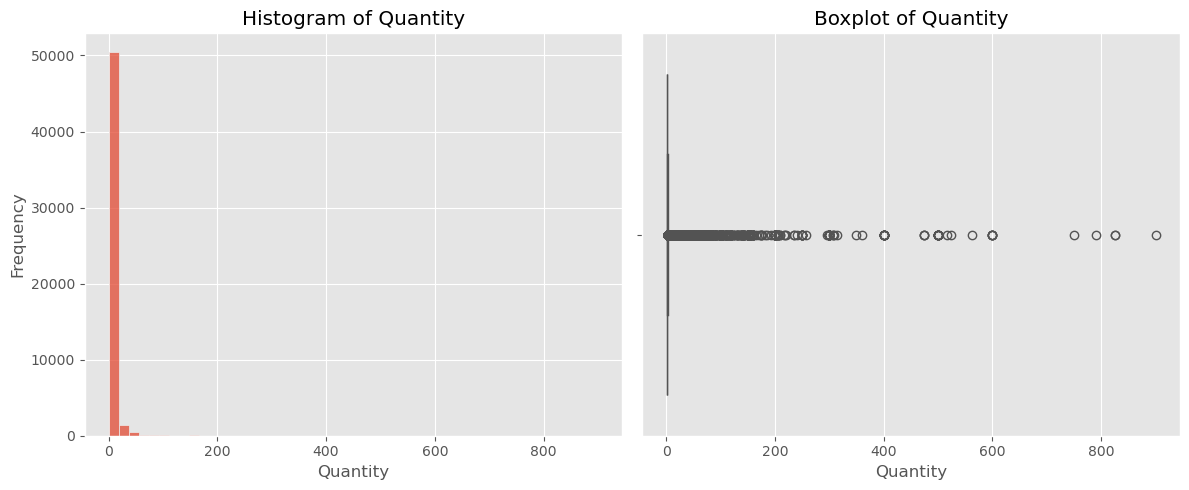

In [20]:
plot_hist_box('Quantity', 49)

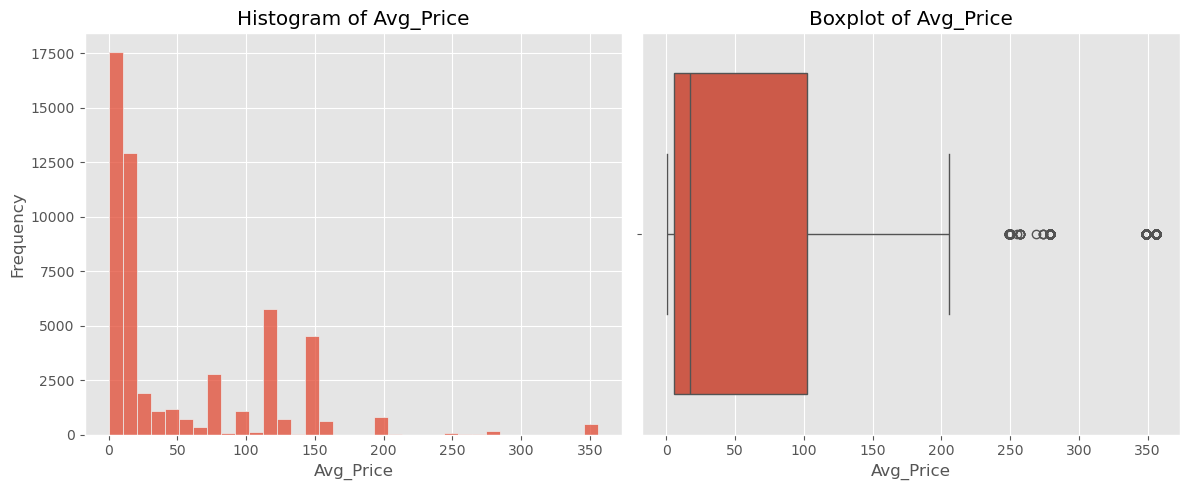

In [21]:
plot_hist_box('Avg_Price', 35)

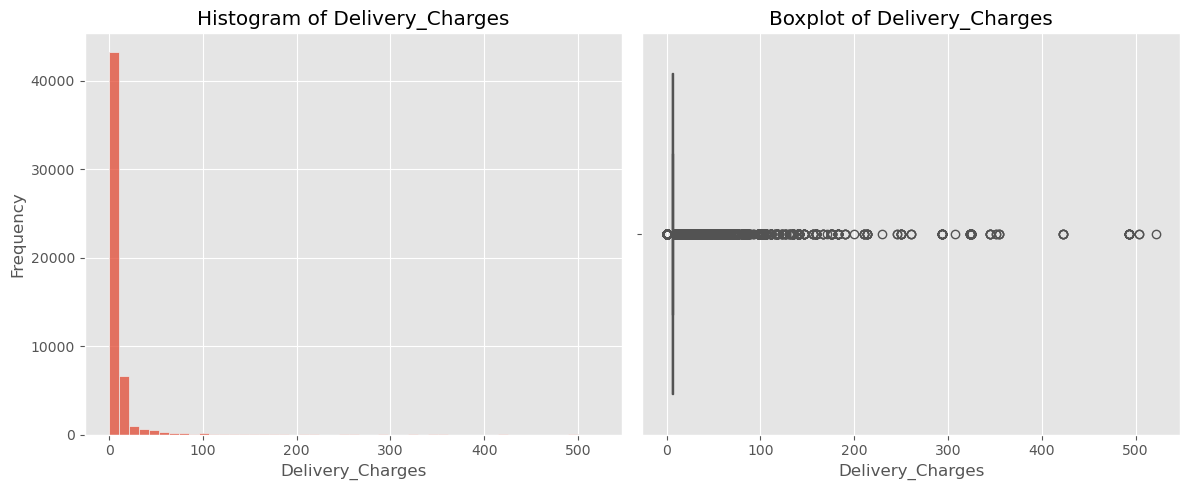

In [22]:
plot_hist_box('Delivery_Charges', 49)

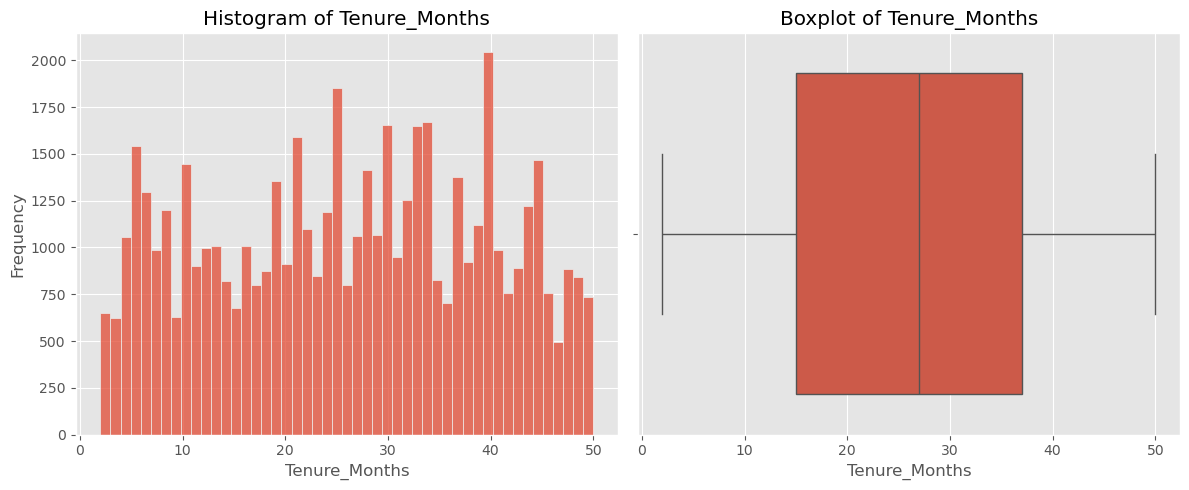

In [23]:
plot_hist_box('Tenure_Months', 49)

Based on the distributions of the numeric variables, the data will be scaled and normalized prior to modeling.

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_merged is your DataFrame

# Function to plot a barplot for a given categorical column in df_merged
def plot_barplot(column_name):
    # Check if the column is indeed categorical
    if df_merged[column_name].dtype == 'object' or df_merged[column_name].dtype.name == 'category':
        # Create a barplot
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column_name, data=df_merged, order = df_merged[column_name].value_counts().index)
        plt.title(f'Bar Plot of {column_name}')
        plt.ylabel('Count')
        plt.xlabel(column_name)
        plt.show()
    else:
        print(f"The column '{column_name}' is not categorical.")




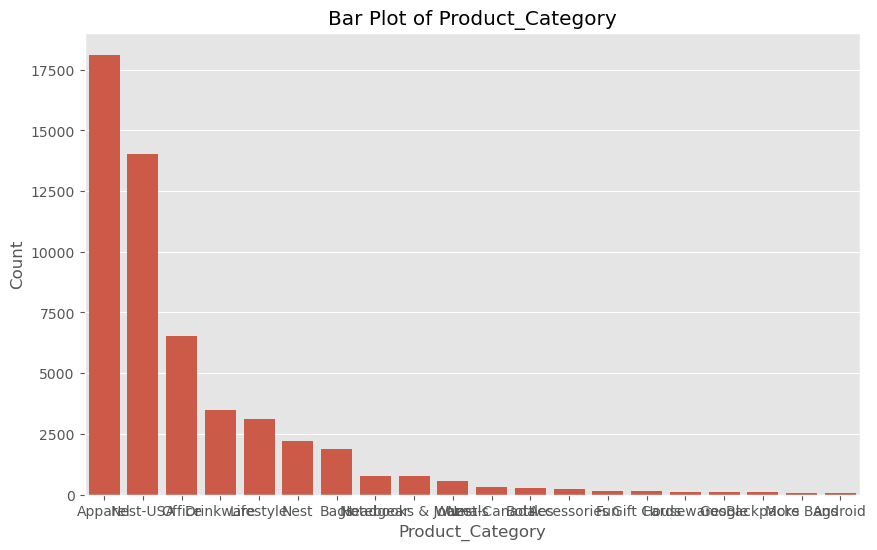

In [26]:
plot_barplot('Product_Category')

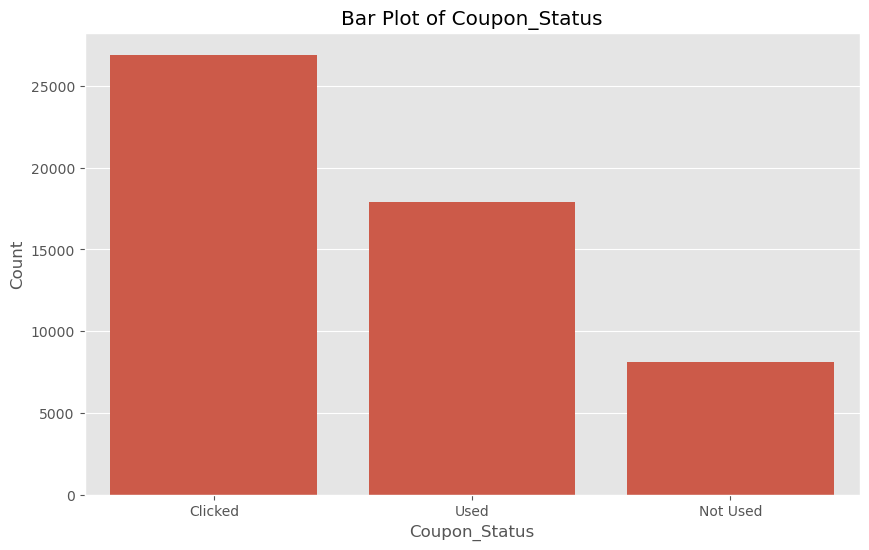

In [27]:
plot_barplot('Coupon_Status')

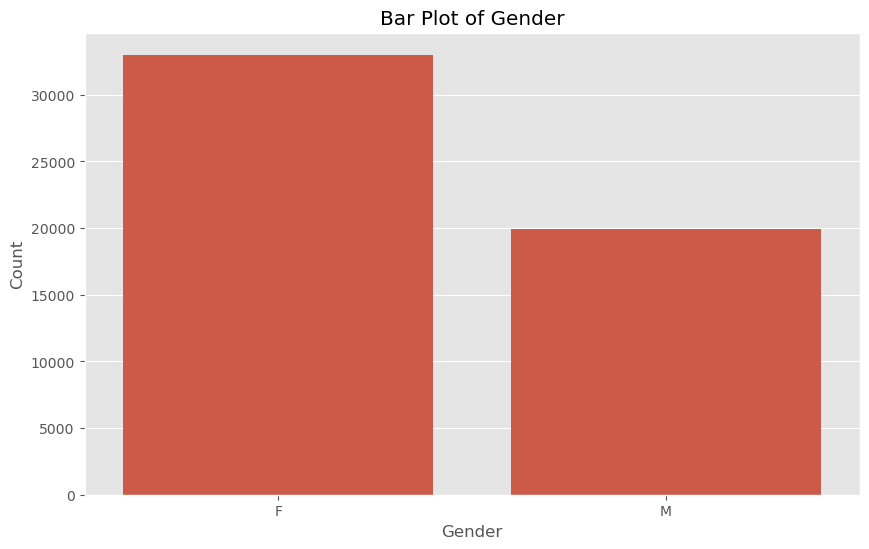

In [28]:
plot_barplot('Gender')

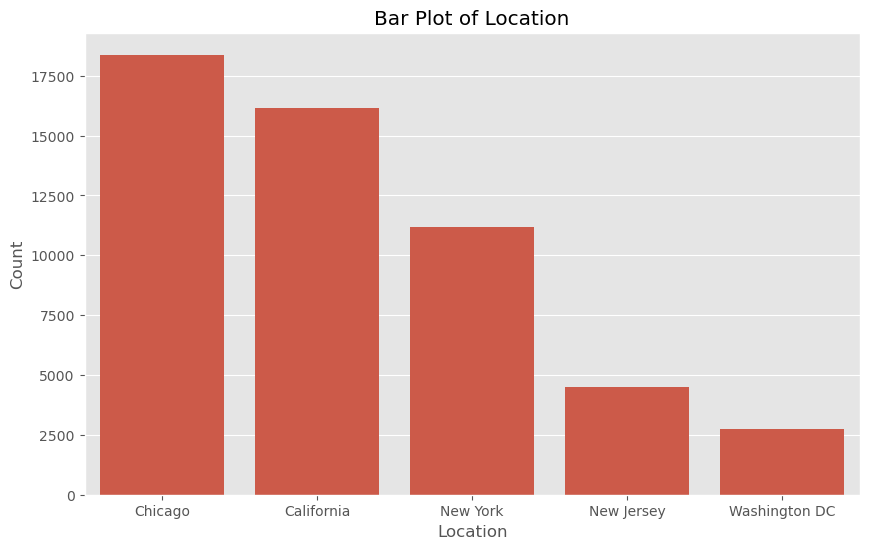

In [29]:
plot_barplot('Location')

## Bivariate Analysis

In [31]:
df_merged.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,M,Chicago,12
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,M,Chicago,12
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,M,Chicago,12


In [32]:
numeric = df_merged[['Quantity', 'Avg_Price', 'Delivery_Charges', 'Tenure_Months']]
numeric.corr()

,Quantity,Avg_Price,Delivery_Charges,Tenure_Months
Quantity,1.000000,-0.113996,0.191383,0.006867
Avg_Price,-0.113996,1.000000,-0.107799,-0.000785
Delivery_Charges,0.191383,-0.107799,1.000000,-0.014848
Tenure_Months,0.006867,-0.000785,-0.014848,1.000000


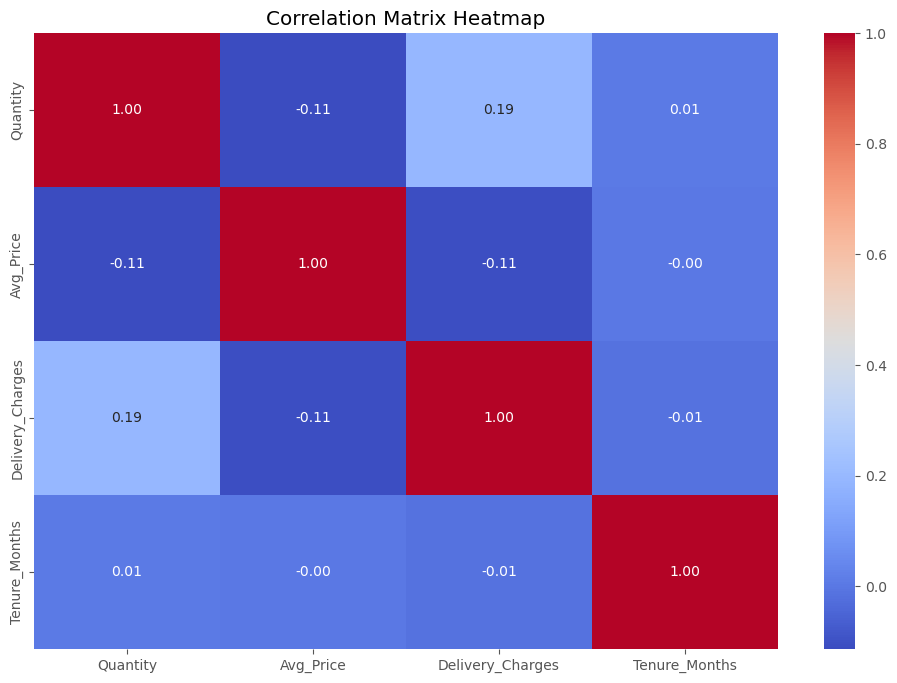

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_merged is your DataFrame

# Calculate the correlation matrix
corr_matrix = numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns)

# Add a title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_merged is your DataFrame

# Function to plot a line plot of a given column against Transaction_Date
def plot_lineplot(column_name):
    if column_name in df_merged.columns and df_merged[column_name].dtype in ['int64', 'float64']:
        # Aggregate the data by month to reduce the number of points
        df_aggregated = df_merged.resample('M', on='Transaction_Date').sum().reset_index()

        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Transaction_Date', y=column_name, data=df_aggregated, color='red')
        plt.title(f'Line Plot of {column_name} over Time')
        plt.xlabel('Transaction Date')
        plt.ylabel(column_name)

        # Format the x-axis dates
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print(f"The column '{column_name}' is not numerical or does not exist in the DataFrame.")

# Example usage
# df_merged['Transaction_Date'] = pd.to_datetime(df_merged['Transaction_Date'])  # Ensure the date column is in datetime format
# plot_lineplot('Quantity')


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_merged is your DataFrame

# Function to plot a line plot of a given column against Transaction_Date
def plot_lineplot(column_name):
    if column_name in df_merged.columns and df_merged[column_name].dtype in ['int64', 'float64']:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Transaction_Date', y=column_name, data=df_merged)
        plt.title(f'Line Plot of {column_name} over Time')
        plt.xlabel('Transaction Date')
        plt.ylabel(column_name)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"The column '{column_name}' is not numerical or does not exist in the DataFrame.")



In [13]:
plot_lineplot('Quantity')

NameError: name 'df_merged' is not defined

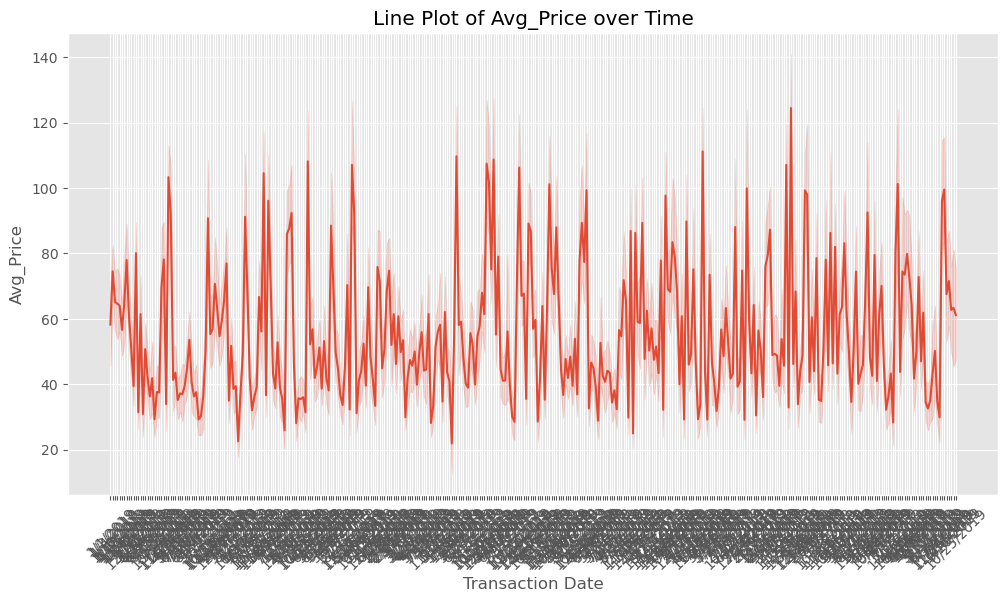

In [36]:
plot_lineplot('Avg_Price')

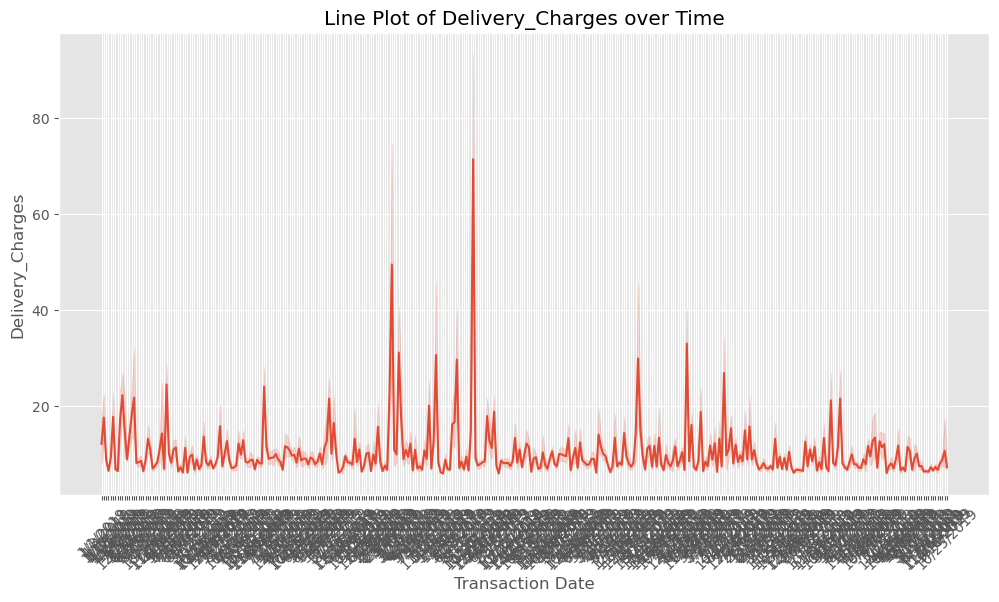

In [37]:
plot_lineplot('Delivery_Charges')

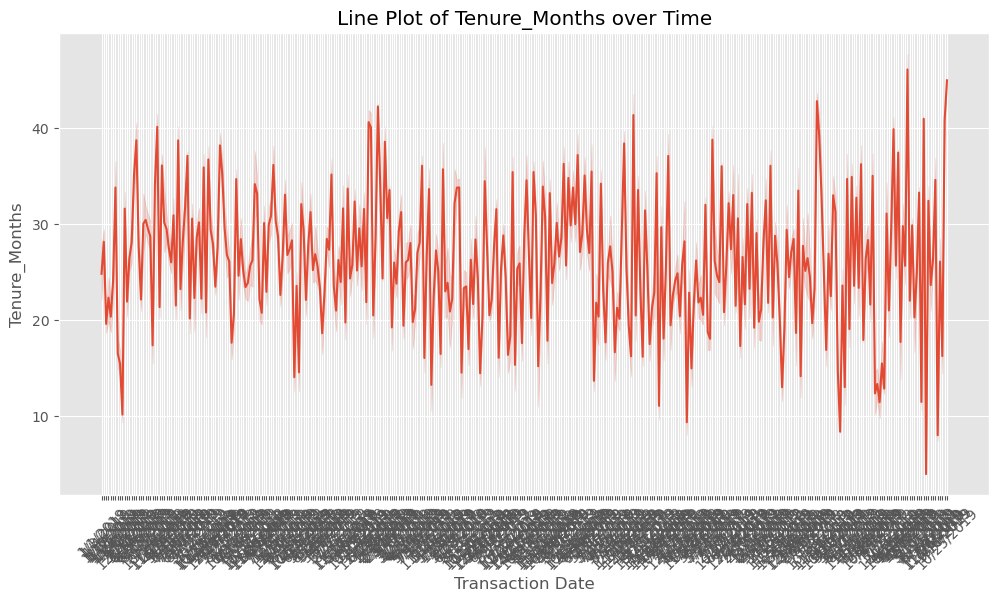

In [38]:
plot_lineplot('Tenure_Months')

In [39]:
df_online_sales['Transaction_Date'].describe()

count          52924
unique           365
top       11/27/2019
freq             335
Name: Transaction_Date, dtype: object

## Preprocessing and Feature Engineering

Next, we preprocess the data by converting dates and calculating new financial metrics, such as total expenditure per transaction and RFM metrics.


In [6]:
# Preprocess the sales data to facilitate further analysis
df_sales['Transaction_Date'] = pd.to_datetime(df_sales['Transaction_Date'])
df_sales['Total_Spent'] = df_sales['Quantity'] * df_sales['Avg_Price'] + df_sales['Delivery_Charges']

# Perform RFM Analysis to understand customer purchasing habits
df_sales['Recency'] = (df_sales['Transaction_Date'].max() - df_sales['Transaction_Date']).dt.days
rfm = df_sales.groupby('CustomerID').agg({
    'Recency': 'min',
    'Transaction_Date': 'count',
    'Total_Spent': 'sum'
}).rename(columns={'Transaction_Date': 'Frequency', 'Total_Spent': 'Monetary'})
rfm['CLV'] = rfm['Monetary'] * 0.1  # Calculate CLV assuming a 10% profit margin

# Merge RFM and customer demographic data
combined_data = pd.merge(rfm, df_customers, on='CustomerID', how='inner')

## Exploratory Data Analysis (EDA)

We perform EDA by plotting histograms of CLV and Tenure Months and generating a correlation matrix to understand the relationships between the features.


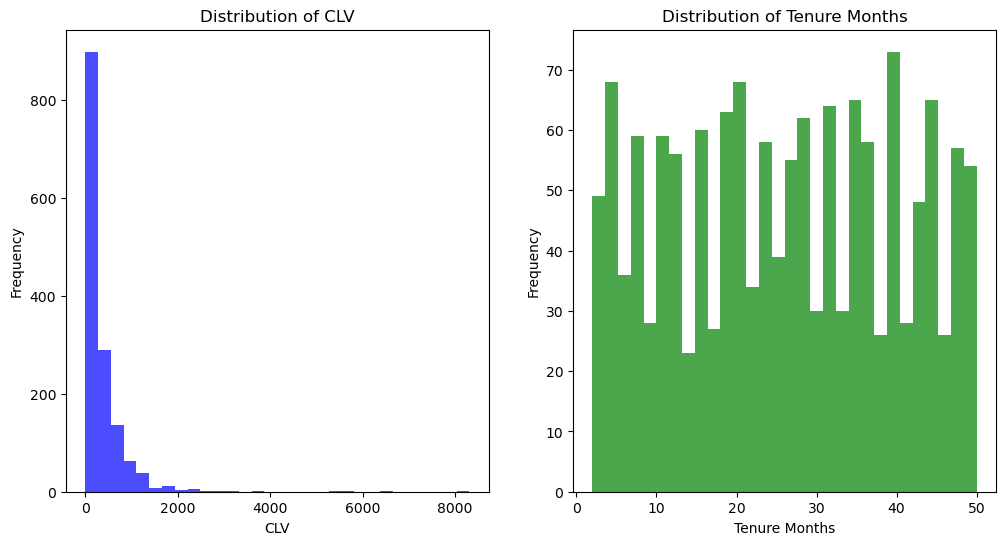

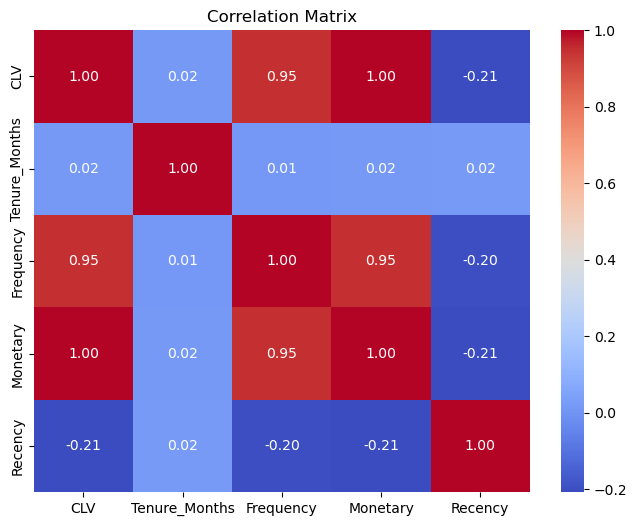

In [8]:
# Visualize distributions of CLV and Tenure Months
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(combined_data['CLV'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of CLV')
plt.xlabel('CLV')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(combined_data['Tenure_Months'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Tenure Months')
plt.xlabel('Tenure Months')
plt.ylabel('Frequency')
plt.show()

# Analyze correlations to identify relationships between variables
correlation_matrix = combined_data[['CLV', 'Tenure_Months', 'Frequency', 'Monetary', 'Recency']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Feature Scaling and Hierarchical Clustering

The features are scaled, and hierarchical clustering is applied to group customers into clusters based on their similarities.


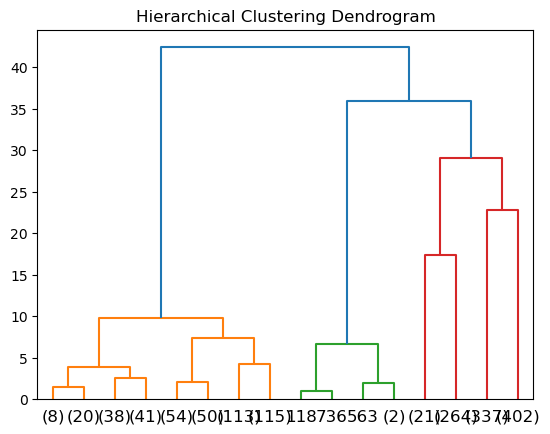

In [10]:
# Standardize features to prepare for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_data[['CLV', 'Tenure_Months']])

# Perform hierarchical clustering using Ward's method
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(scaled_features)

# Visualize the hierarchical clustering results with a dendrogram
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linkage(scaled_features, method='ward'), truncate_mode='level', p=3)
plt.show()

## Determining the Number of Clusters

The silhouette scores are calculated for different numbers of clusters to determine the optimal clustering solution.


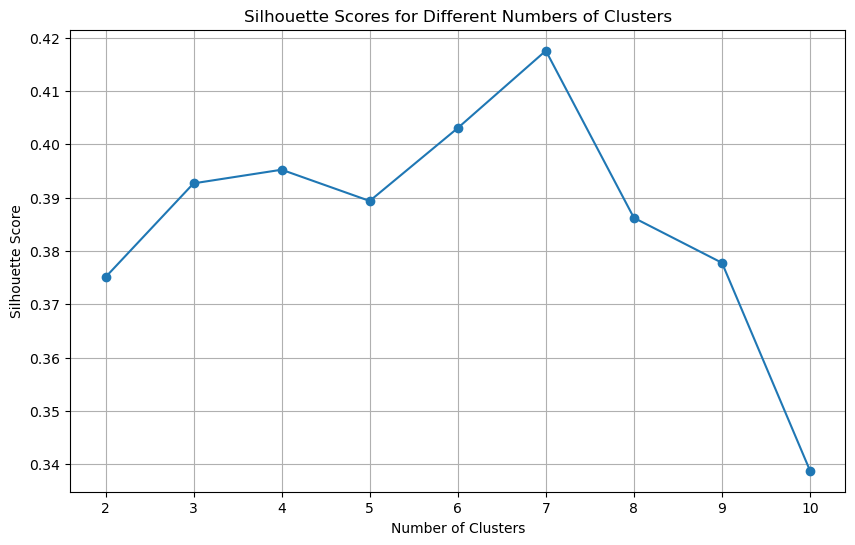

In [12]:
# Calculate silhouette scores to determine the optimal number of clusters
silhouette_scores = {}
for n_clusters in range(2, 11):
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    labels = cluster_model.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores[n_clusters] = score

# Plot silhouette scores to find the optimal cluster number
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Select the optimal cluster count based on silhouette analysis
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
optimal_cluster_model = AgglomerativeClustering(n_clusters=optimal_clusters, affinity='euclidean', linkage='ward')
optimal_cluster_labels = optimal_cluster_model.fit_predict(scaled_features)

## Cluster Visualization with PCA

We use PCA to reduce the dimensionality of our features to two principal components, making it easier to visualize the clusters.


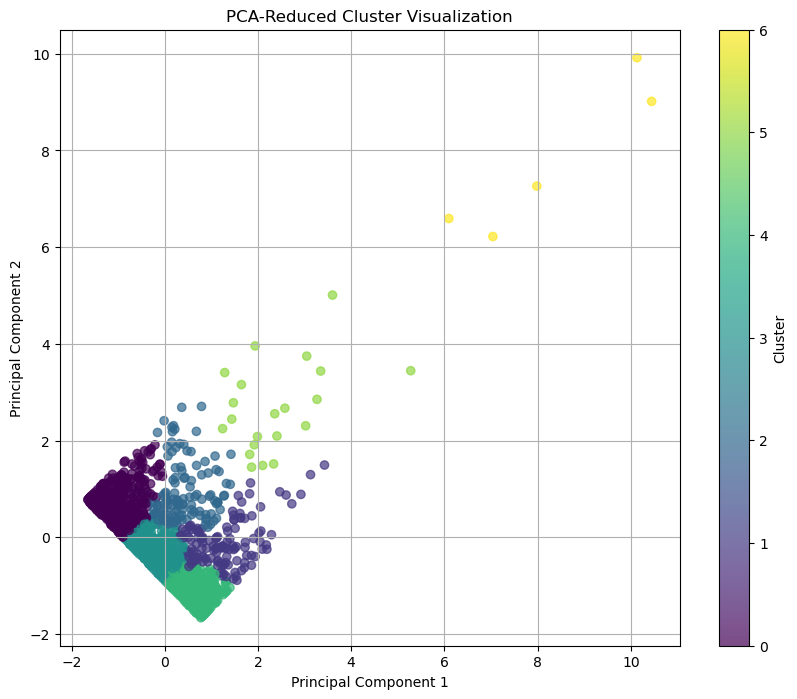

In [14]:
# Use PCA for dimensionality reduction to facilitate visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=optimal_cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA-Reduced Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

## Summary of Cluster Characteristics

Finally, we summarize and interpret the characteristics of each cluster, helping to understand the distinct behaviors and traits of customer groups.


In [16]:
# Summarize and interpret the characteristics of each cluster
clustered_data = combined_data.copy()
clustered_data['Cluster'] = optimal_cluster_labels
cluster_characteristics = clustered_data.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std'],
    'CLV': ['mean', 'median', 'std'],
    'Tenure_Months': ['mean', 'median', 'std']
}).round(2)
print("Cluster Characteristics:")
print(cluster_characteristics)

Cluster Characteristics:
        Recency                Frequency                Monetary            \
           mean median     std      mean median    std      mean    median   
Cluster                                                                      
0        146.01  136.0   99.28     26.12   18.0  22.67   2449.97   1828.23   
1        115.83   82.0  102.18     77.45   64.5  40.74   7863.57   6794.04   
2        102.11   76.0   88.71     82.40   77.0  37.35   8698.69   8216.38   
3        158.53  151.0   99.74     17.07   14.0  13.60   1437.51   1137.62   
4        157.88  145.0  104.79     18.91   16.0  14.26   1657.71   1288.32   
5         85.24   36.0  101.30    199.95  193.0  76.88  23626.69  22177.12   
6         29.20   12.0   43.93    590.40  575.0  63.39  67599.88  64045.50   

                       CLV                   Tenure_Months                
              std     mean   median      std          mean median    std  
Cluster                                     

Cluster Characteristics Summary:

- Cluster 0: Customers with average recency, lower frequency, and moderate monetary value- 
- Cluster 1: Moderate recency and higher frequency and monetary value.
- Cluster 2: Similar to Cluster 1 but with slightly lower recency and higher monetary value.
- Cluster 3: High recency, very low frequency, and the lowest monetary value.
- Cluster 4: High recency, low frequency, and low monetary value but slightly higher than Cluster 3.
- Cluster 5: Lower recency, very high frequency, and very high monetary value.
- Cluster 6: Very low recency, extremely high frequency, and the highest monetary value.

Interpretations:
- Cluster 0 & 4 (Low Engagement): These customers engage less frequently and spend less compared to other clusters. Cluster 0 has slightly better engagement than Cluster 4.
- Cluster 3 (At Risk): Customers in this cluster have high recency and very low frequency and monetary contributions, indicating they are at risk of churning.
- Cluster 1 & 2 (Loyal Customers): These customers are quite similar, showcasing moderate to low recency and high monetary contributions. They are frequent shoppers.
- Cluster 5 & 6 (VIPs/Champions): These are your most valuable customers, with the lowest recency and highest frequency and monetary contributions. They are crucial to the business.

Business Recommendations:
- For Clusters 0 & 4 (Low Engagement): Implement targeted marketing campaigns to increase their purchasing frequency. Offering personalized promotions and new product introductions can help increase engagement.
- For Cluster 3 (At Risk): Immediate action is needed to re-engage these customers. Consider sending "We Miss You" emails with special discounts or loyalty rewards to encourage them to shop again.
- For Clusters 1 & 2 (Loyal Customers): Focus on loyalty programs to maintain their current engagement level. Exclusive offers, early access to new products, and special loyalty discounts can help enhance their satisfaction and retention.
- For Clusters 5 & 6 (VIPs/Champions): Provide VIP treatment. This could include exclusive memberships, personal shopping assistants, and premium support services. Recognizing their value with exclusive VIP events or partnerships with other high-value brands could also be beneficial.
